In [1]:
## knjižnice:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import arch

In [2]:
## podatki, ki so nam jih poslali:
podatki = pd.read_csv(os.path.join('C:/Users/Uporabnik/OneDrive/Namizje/SOLA/MAGISTERIJ/MATEMATIKA Z RACUNALNIKOM/GospodinjskiOdjemalci.csv'), sep=";")
# Malo boljši format:
podatki['DateTimeStartUTC'] = pd.to_datetime(podatki['DateTimeStartUTC'], format='%d.%m.%Y %H:%M')
podatki['DateTimeStartCET'] = pd.to_datetime(podatki['DateTimeStartCET'], format='%d.%m.%Y %H:%M')

podatki = podatki[['DateTimeStartUTC', 'Odjem ACT', 'Temperatura ACT', 'Temperatura FC', 'Sevanje ACT', 'Sevanje FC']]

podatki.set_index('DateTimeStartUTC', inplace=True)
podatki['Year'] = podatki.index.year
podatki['Month'] = podatki.index.month
podatki['Day'] = podatki.index.date

podatki = podatki.asfreq('15T')

podatki['Odjem ACT'] = podatki['Odjem ACT'] * 1000000000 # da dobim MWh (bo lepše pri logaritmu tega stolpce v nadaljevanju)

podatki


,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day
DateTimeStartUTC,,,,,,,,
2021-10-31 23:00:00,9508.67,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:15:00,9168.37,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:30:00,8860.11,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:45:00,8510.97,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-11-01 00:00:00,8332.21,3.45,5.300,0.0,0.0,2021,11,2021-11-01
...,...,...,...,...,...,...,...,...
2024-02-29 21:45:00,12005.50,6.80,7.475,0.0,0.0,2024,2,2024-02-29
2024-02-29 22:00:00,11336.40,6.65,7.300,0.0,0.0,2024,2,2024-02-29
2024-02-29 22:15:00,10796.70,6.50,7.300,0.0,0.0,2024,2,2024-02-29


In [3]:
sns.set(rc={'figure.figsize':(20, 6)}) # sets the default figure size
plt.style.use('seaborn-whitegrid')

C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_8052\2033026033.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<AxesSubplot: xlabel='DateTimeStartUTC'>

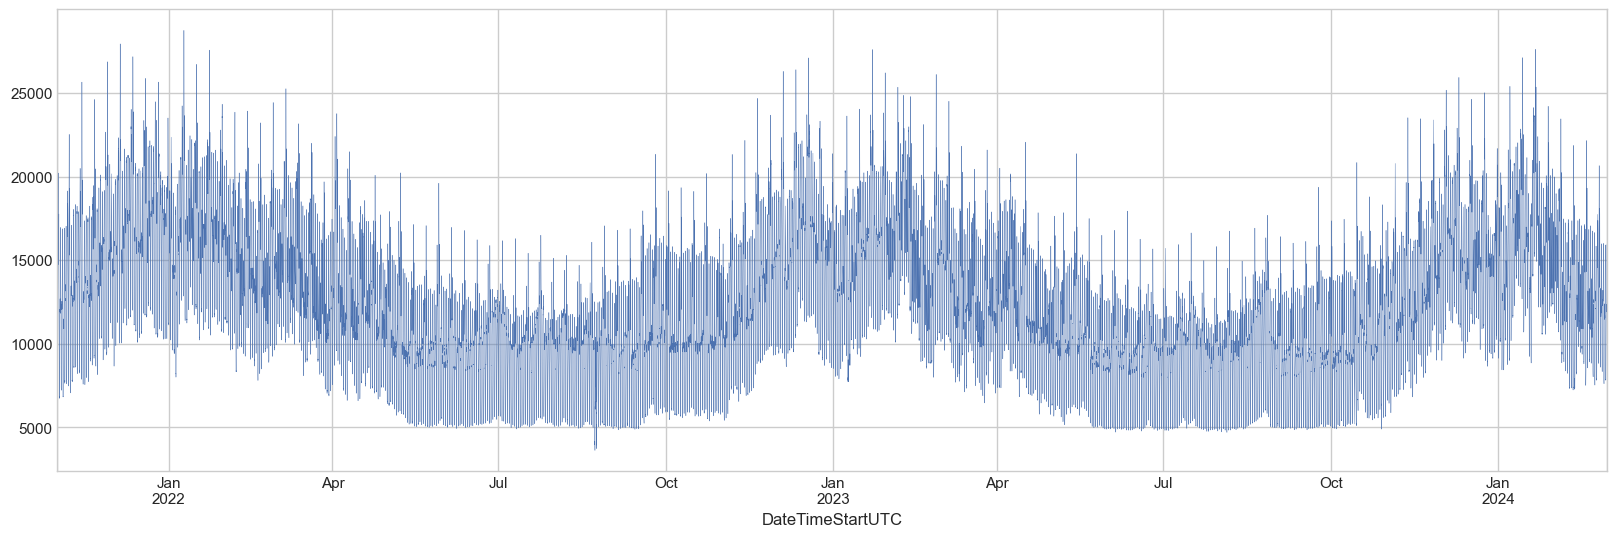

In [153]:
podatki['Odjem ACT'].plot(linewidth=0.3)

In [4]:
podatki['log return'] = np.log(podatki['Odjem ACT']/podatki['Odjem ACT'].shift(-1))
podatki = podatki.dropna()
podatki

,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day,log return
DateTimeStartUTC,,,,,,,,,
2021-10-31 23:00:00,9508.67,3.60,5.300,0.0,0.0,2021,10,2021-10-31,0.036444
2021-10-31 23:15:00,9168.37,3.60,5.300,0.0,0.0,2021,10,2021-10-31,0.034200
2021-10-31 23:30:00,8860.11,3.60,5.300,0.0,0.0,2021,10,2021-10-31,0.040203
2021-10-31 23:45:00,8510.97,3.60,5.300,0.0,0.0,2021,10,2021-10-31,0.021227
2021-11-01 00:00:00,8332.21,3.45,5.300,0.0,0.0,2021,11,2021-11-01,0.004812
...,...,...,...,...,...,...,...,...,...
2024-02-29 21:30:00,12529.80,6.85,7.650,0.0,0.0,2024,2,2024-02-29,0.042745
2024-02-29 21:45:00,12005.50,6.80,7.475,0.0,0.0,2024,2,2024-02-29,0.057346
2024-02-29 22:00:00,11336.40,6.65,7.300,0.0,0.0,2024,2,2024-02-29,0.048778


<AxesSubplot: xlabel='DateTimeStartUTC'>

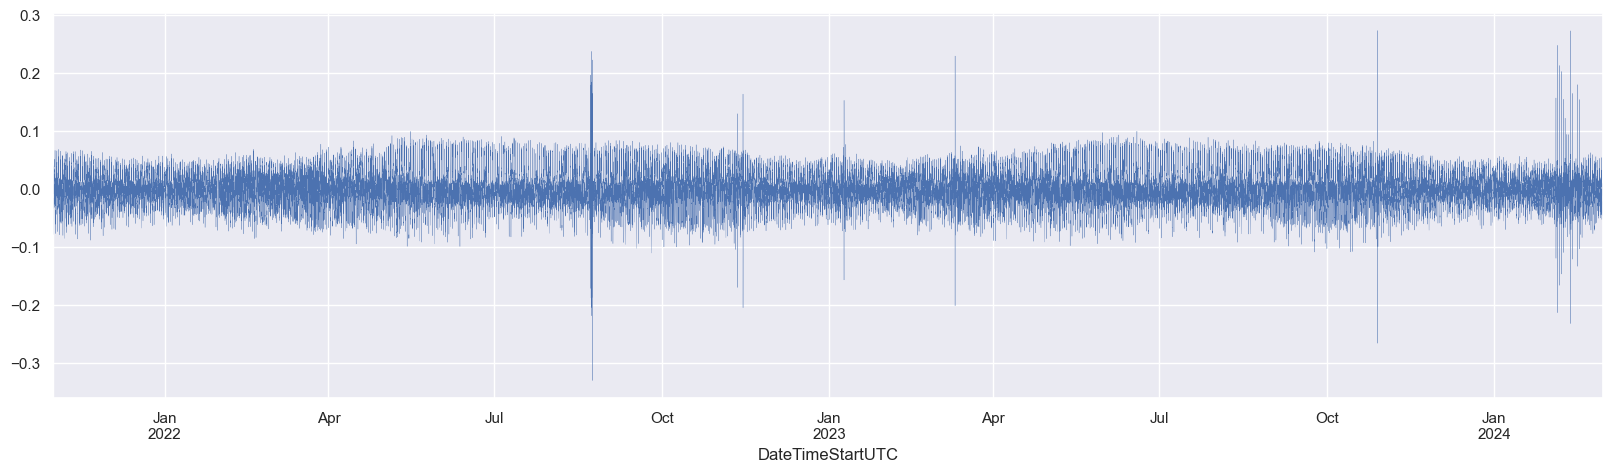

In [8]:
podatki['log return'].plot(linewidth=0.3)
# to je ful bolj stacionarno

In [9]:
from arch.unitroot import *

def preveri_stacionarnost(ts):
    print(ADF(ts).summary())
    print('\n')
    print(KPSS(ts).summary())
    print('\n')
    print(PhillipsPerron(ts).summary())

In [11]:
preveri_stacionarnost(podatki['log return'])

# vsi testi povedo, da je časovna vrsta stacionarna

   Augmented Dickey-Fuller Results   
Test Statistic                -83.893
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


    KPSS Stationarity Test Results   
Test Statistic                  0.001
P-value                         1.000
Lags                              133
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


     Phillips-Perron Test (Z-tau)    
Test Statistic                -58.607
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
N

Text(0.5, 1.0, 'ACF na log return')

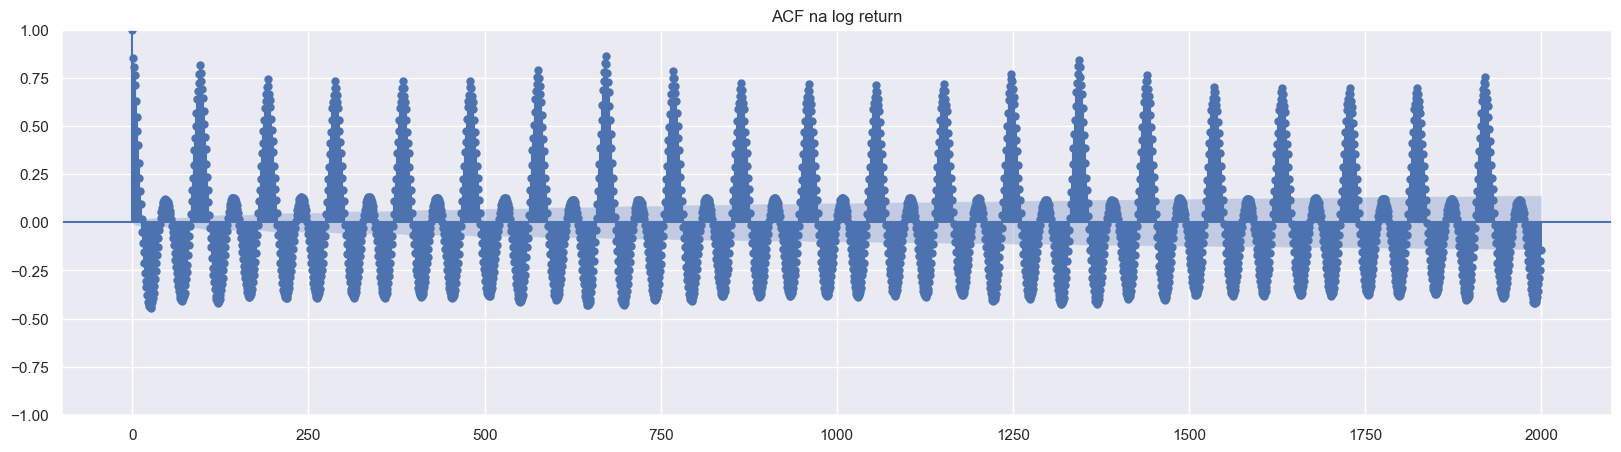

In [14]:
tsaplots.plot_acf(podatki['log return'], lags=1000)
plt.ylim(-1,1)
plt.title('ACF na log return')

# očitno je, da imamo sezonskost, zato sezonsko diferenciramo

Text(0.5, 1.0, 'Log return, ki je sezonsko diferenciran s periodo 96')

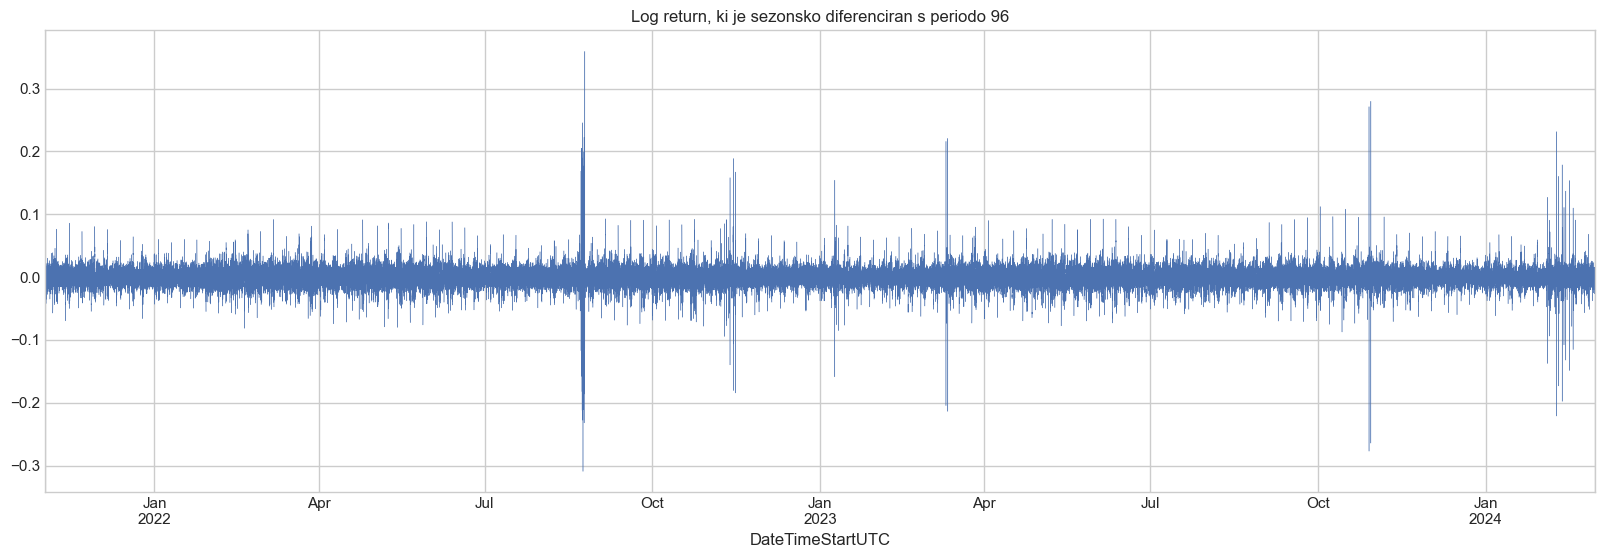

In [6]:
ts_diff = podatki['log return'].diff(periods = 96).dropna()
ts_diff.plot(linewidth=0.3) 
plt.title('Log return, ki je sezonsko diferenciran s periodo 96')

Text(0.5, 1.0, 'ACF po prvem sezonskem diferenciranju')

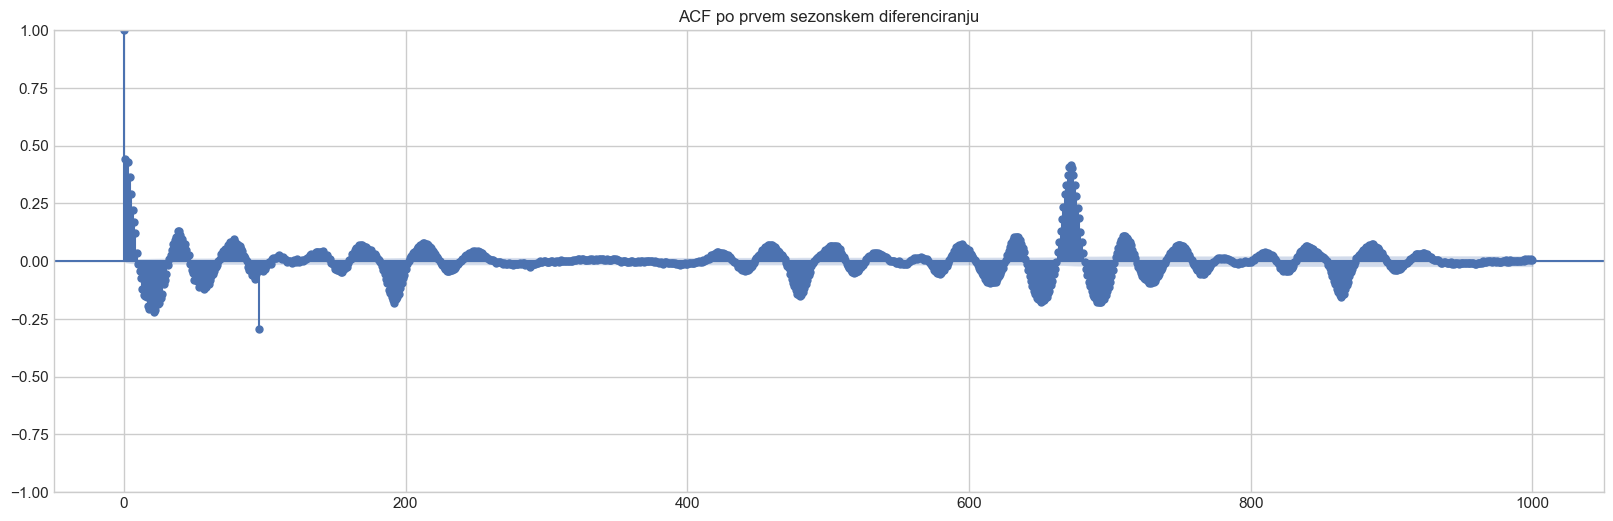

In [24]:
tsaplots.plot_acf(ts_diff, lags=1000)
plt.ylim(-1,1)
plt.title('ACF po prvem sezonskem diferenciranju')

Text(0.5, 1.0, 'ACF po prvem sezonskem diferenciranju, zoženo')

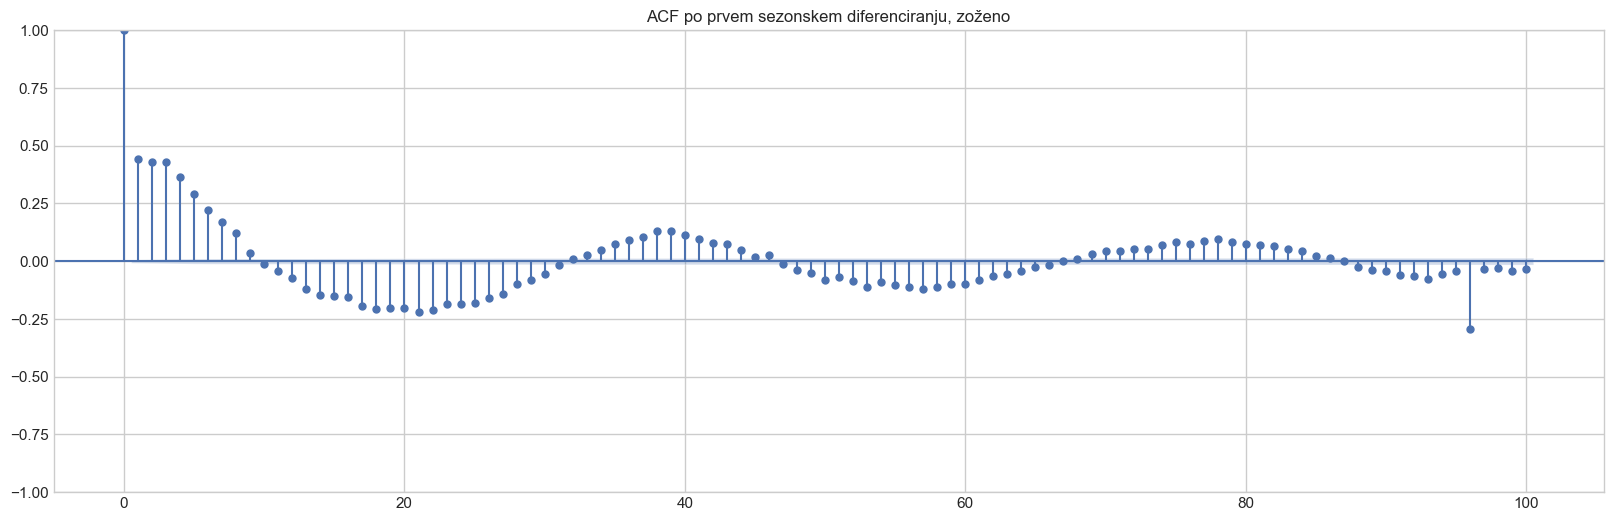

In [25]:
tsaplots.plot_acf(ts_diff, lags=100)
plt.ylim(-1,1)
plt.title('ACF po prvem sezonskem diferenciranju, zoženo')

Text(0.5, 1.0, 'Po drugem diferenciranju')

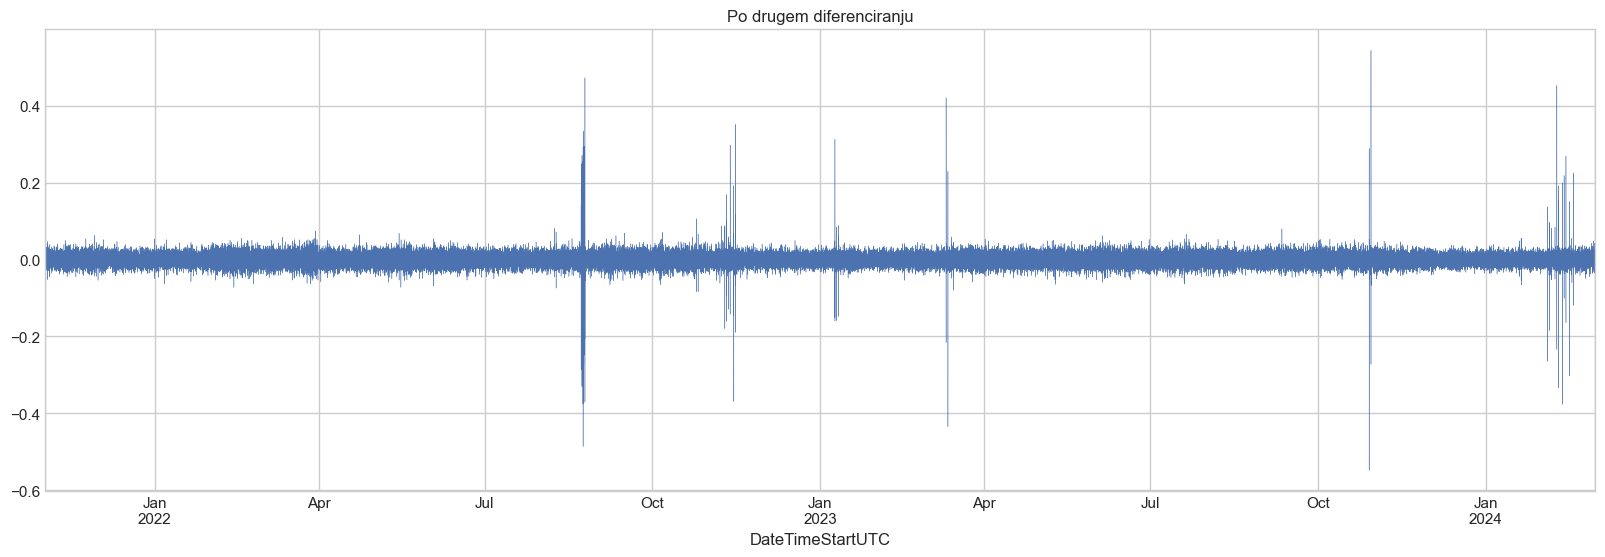

In [26]:
ts_diff_2 = ts_diff.diff().dropna()
ts_diff_2.plot(linewidth=0.3) 
plt.title('Po drugem diferenciranju')

Text(0.5, 1.0, 'ACF po drugem diferenciranju')

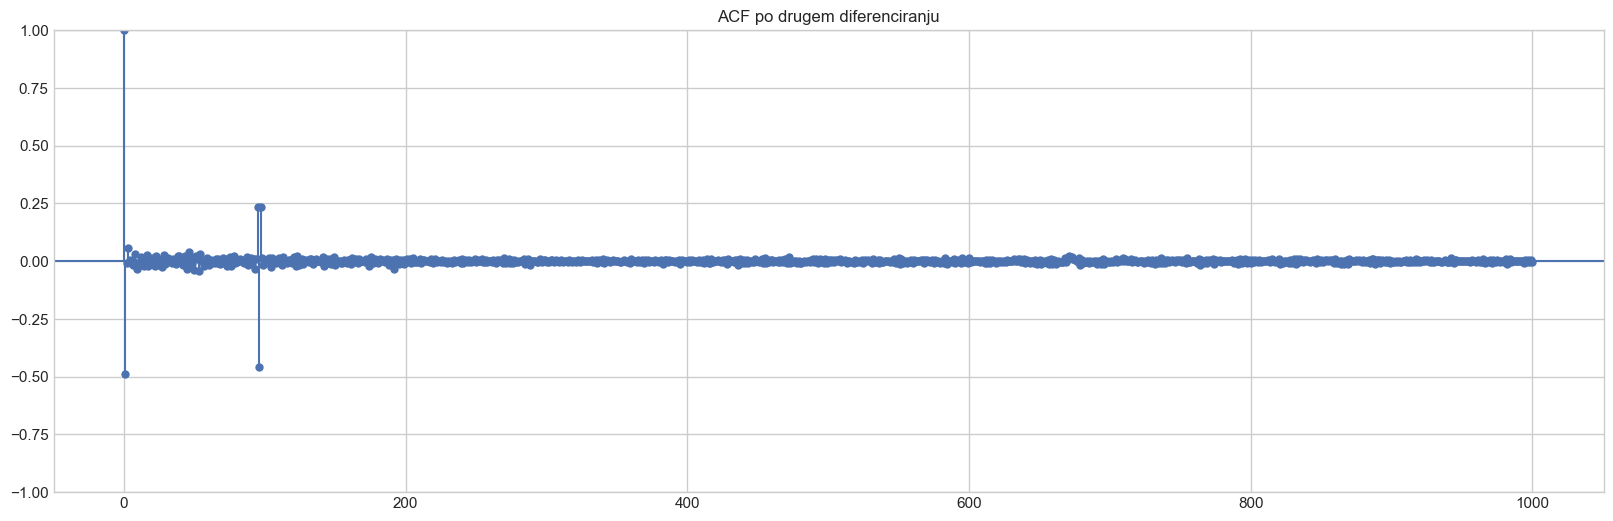

In [27]:
tsaplots.plot_acf(ts_diff_2, lags=1000)
plt.ylim(-1,1)
plt.title('ACF po drugem diferenciranju')

Text(0.5, 1.0, 'ACF po drugem diferenciranju, zoženo')

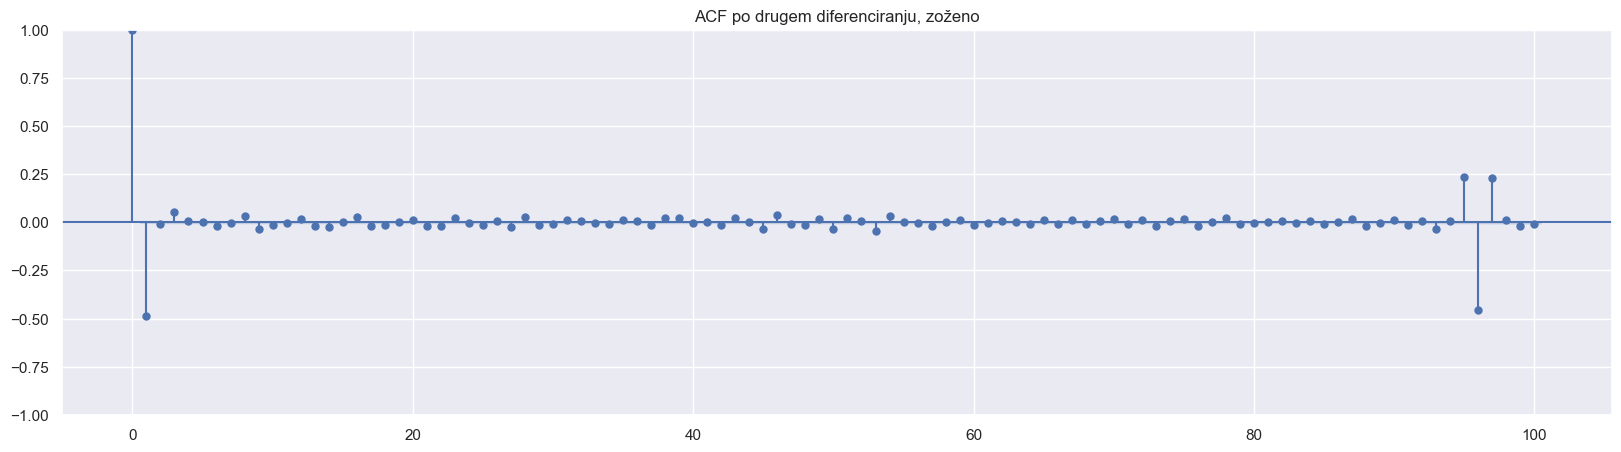

In [26]:
tsaplots.plot_acf(ts_diff_2, lags=100)
plt.ylim(-1,1)
plt.title('ACF po drugem diferenciranju, zoženo')

# q je 1 ali pa 95

Text(0.5, 1.0, 'PACF po drugem diferenciranju')

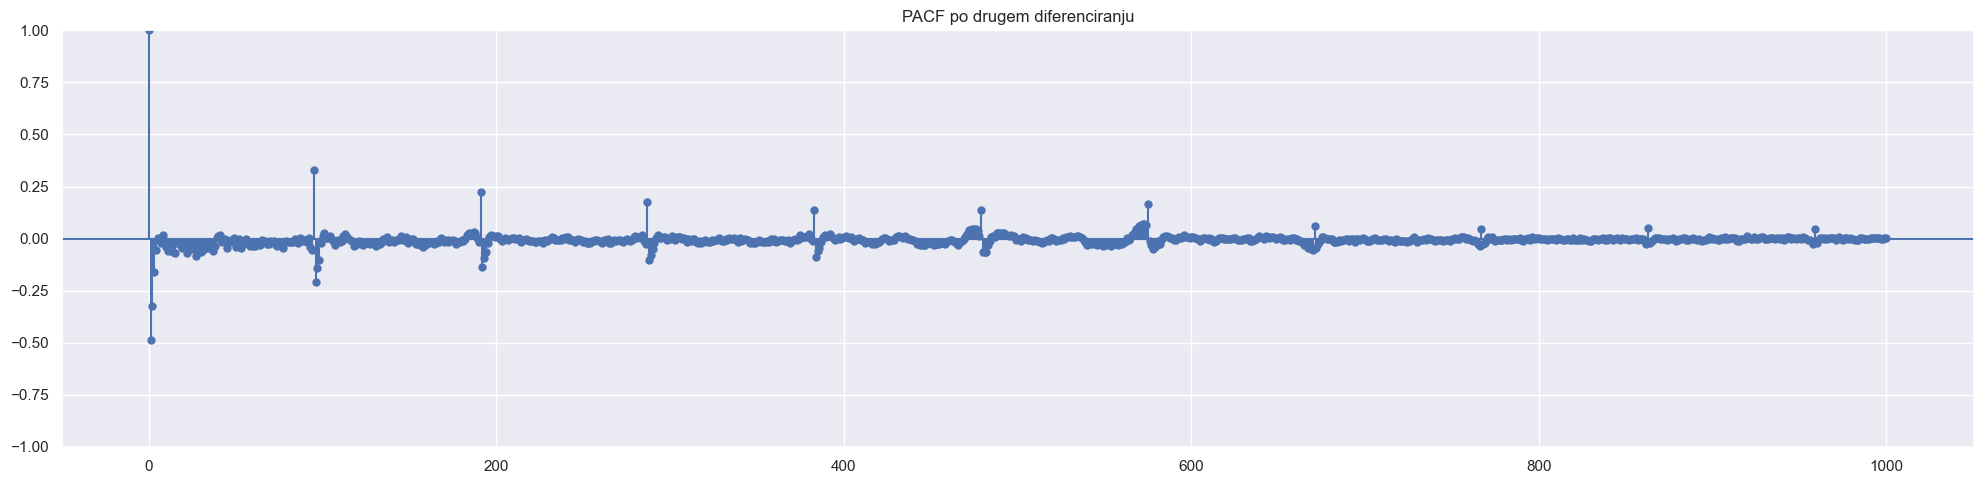

In [25]:
tsaplots.plot_pacf(ts_diff_2, lags=1000, method="ywm")
plt.ylim(-1,1)
plt.title('PACF po drugem diferenciranju')

Text(0.5, 1.0, 'PACF po drugem diferenciranju, zoženo')

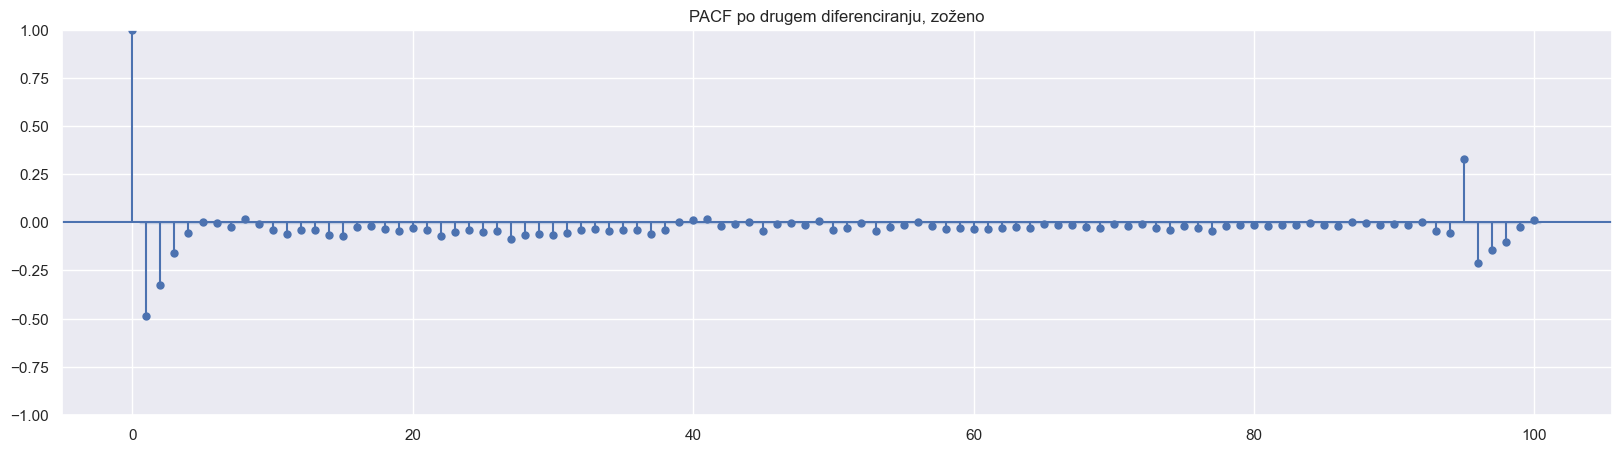

In [27]:
tsaplots.plot_pacf(ts_diff_2, lags=100, method="ywm")
plt.ylim(-1,1)
plt.title('PACF po drugem diferenciranju, zoženo')

# p je 1, 2, 3 ali 95

In [28]:
preveri_stacionarnost(ts_diff_2)

# vsi testi povedo, da je stacionarna

   Augmented Dickey-Fuller Results   
Test Statistic                -64.756
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


    KPSS Stationarity Test Results   
Test Statistic                  0.002
P-value                         1.000
Lags                              243
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


     Phillips-Perron Test (Z-tau)    
Test Statistic              -1501.246
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
N

In [7]:
# TRAIN na 75 % (od 2021-11-01 23:00:00 do 2023-08-04 23:45:00)
# TEST na 25 %

start = 0
end = 61540

# train data:
df = podatki[(start+96):(end+96)]

train_data_log = df['log return']
train_data_diff_96 = ts_diff[(start):(end)] # !!
train_exog = df[['Temperatura FC', 'Sevanje FC']]

# test data:
df_test = podatki[(end+96):(end+96+96)]

day = '2023-08-05'

test_data_log = df_test['log return']
test_data_diff_96 = ts_diff[end:(end+96)] # !!
test_exog = df_test[['Temperatura FC', 'Sevanje FC']]

df

,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day,log return
DateTimeStartUTC,,,,,,,,,
2021-11-01 23:00:00,8154.07,10.200,10.300,1.0,0.0,2021,11,2021-11-01,0.037810
2021-11-01 23:15:00,7851.52,10.200,10.225,1.0,0.0,2021,11,2021-11-01,0.034879
2021-11-01 23:30:00,7582.39,10.200,10.150,0.5,0.0,2021,11,2021-11-01,0.032879
2021-11-01 23:45:00,7337.14,10.200,10.075,0.0,0.0,2021,11,2021-11-01,0.016360
2021-11-02 00:00:00,7218.08,10.200,10.000,0.5,0.0,2021,11,2021-11-02,0.013121
...,...,...,...,...,...,...,...,...,...
2023-08-04 22:45:00,5631.10,15.925,15.925,0.0,0.0,2023,8,2023-08-04,0.025016
2023-08-04 23:00:00,5491.98,15.800,15.900,1.0,0.0,2023,8,2023-08-04,0.035914
2023-08-04 23:15:00,5298.24,15.800,15.925,1.0,0.0,2023,8,2023-08-04,0.017986


In [92]:
# delala bom na ts_diff (torej na 1x sezonsko diferenciranih) --> d = 1 
# na koncu bom oddiferencirala in naredila inverz od log returns da pridem nazaj na originalno skalo

In [8]:
def RMSE_MAPE (podatki_OG, napoved):
    '''Funkcija RMSE_MAPE izračuna napaki RMSE in MAPE. Vrne seznam oblike [RMSE, MAPE]'''
    errors = podatki_OG - napoved
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(errors / podatki_OG)) * 100
    return [rmse, mape]

def napoved_inverz (podatki, napoved, dan, naslednji_dan):
    '''Napoved je narejena na log returns. Funkcija napoved_inverz pa jo pretvori nazaj na originalno skalo, podatke.'''
    start = dan + ' 00:00:00'
    end = naslednji_dan + ' 00:00:00'
    return(np.exp(napoved + np.log(podatki.loc[start:end, 'Odjem ACT'].shift(-1)[dan])))

def izrisi_graf_napovedi (podatki, napoved, naslov):
    '''Funkcija izrisi_graf_napovedi izriše graf napovedi'''
    plt.style.use('seaborn-whitegrid')
    plt.plot(podatki, label='Dejanski podatki', color='gray')
    plt.plot(napoved, label='Napovedani podatki', color='orangered')
    plt.title(naslov, fontsize=15)
    plt.xlabel('Čas')
    plt.ylabel('Odjem [kWh]')
    plt.legend()
    plt.show()

In [93]:
# model_1 = sm.tsa.statespace.SARIMAX(train_data_log, order=(5,1,4), seasonal_order=(0,1,0,96))
# results_1 = model_1.fit()

# # 7 min

In [94]:
# test_forecast = results_1.forecast(steps=96)


# # import math

# napoved = np.exp(test_forecast + np.log(podatki.loc['2023-04-01 00:00:00':'2023-04-02 00:00:00', 'Odjem ACT'].shift(-1)['2023-04-01']))
# napoved

# plt.plot(podatki.loc['2023-04-01', 'Odjem ACT'], label='Actual Data', color='gray')
# plt.plot(napoved, label='Forecasted Data', color='orangered')
# plt.title('ARIMA Model Evaluation')
# plt.xlabel('Date')
# plt.ylabel('Odjem')
# plt.legend()
# plt.show()

In [95]:
# sarima_residuals_1 = results_1.resid
# sarima_residuals_1
# plt.plot(sarima_residuals_1)

In [96]:
# tsaplots.plot_acf(sarima_residuals_1, lags=100)
# plt.ylim(-1,1)
# plt.title('ACF SARIMA')

In [97]:
# tsaplots.plot_pacf(sarima_residuals_1, lags=100)
# plt.ylim(-1,1)
# plt.title('PACF SARIMA')

In [98]:
# # fit a GARCH(2,2) model on the residuals of the SARIMA model

# modelGARCH = arch.arch_model(sarima_residuals_1, mean='Zero', vol='Garch', p=1, q=1)
# resultGarch = modelGARCH.fit()
# forecastGARCH = resultGarch.forecast(horizon=96)


# # združimo SARIMO in GARCH
# forecast = test_forecast.mean() + forecastGARCH.variance.values[-1, :]
# forecast

# forecastDf = pd.DataFrame(forecast, index=test_forecast.index, columns=['Forecast'])
# forecastDf

# napoved_ARIMA_GARCH = np.exp(forecastDf['Forecast'] + np.log(podatki.loc['2023-04-01 00:00:00':'2023-04-02 00:00:00', 'Odjem ACT'].shift(-1)['2023-04-01']))
# napoved_ARIMA_GARCH

# plt.style.use('seaborn-whitegrid')

# plt.plot(podatki.loc['2023-04-01', 'Odjem ACT'], label='Actual Data', color='gray')
# plt.plot(napoved_ARIMA_GARCH, label='Forecasted Data', color='orangered')
# plt.title('ARIMA Model Evaluation', fontsize=15)
# plt.xlabel('Date')
# plt.ylabel('Odjem')
# plt.legend()
# plt.show()



In [99]:
# resultGarch.summary()

In [167]:
# SARIMA 
[RMSE_SARIMA, MAPE_SARIMA] = RMSE_MAPE(podatki.loc['2023-04-01', 'Odjem ACT'] , napoved)

[RMSE_SARIMA_GARCH, MAPE_SARIMA_GARCH] = RMSE_MAPE(podatki.loc['2023-04-01', 'Odjem ACT'] , napoved_ARIMA_GARCH)

print(RMSE_SARIMA, MAPE_SARIMA)
print(RMSE_SARIMA_GARCH, MAPE_SARIMA_GARCH)


345.93778404627676 2.10478657820608
390.4208141274457 2.5715234851461335


In [16]:
model_2 = sm.tsa.statespace.SARIMAX(train_data_log, order=(5,1,4), exog = train_exog)
results_2 = model_2.fit()

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


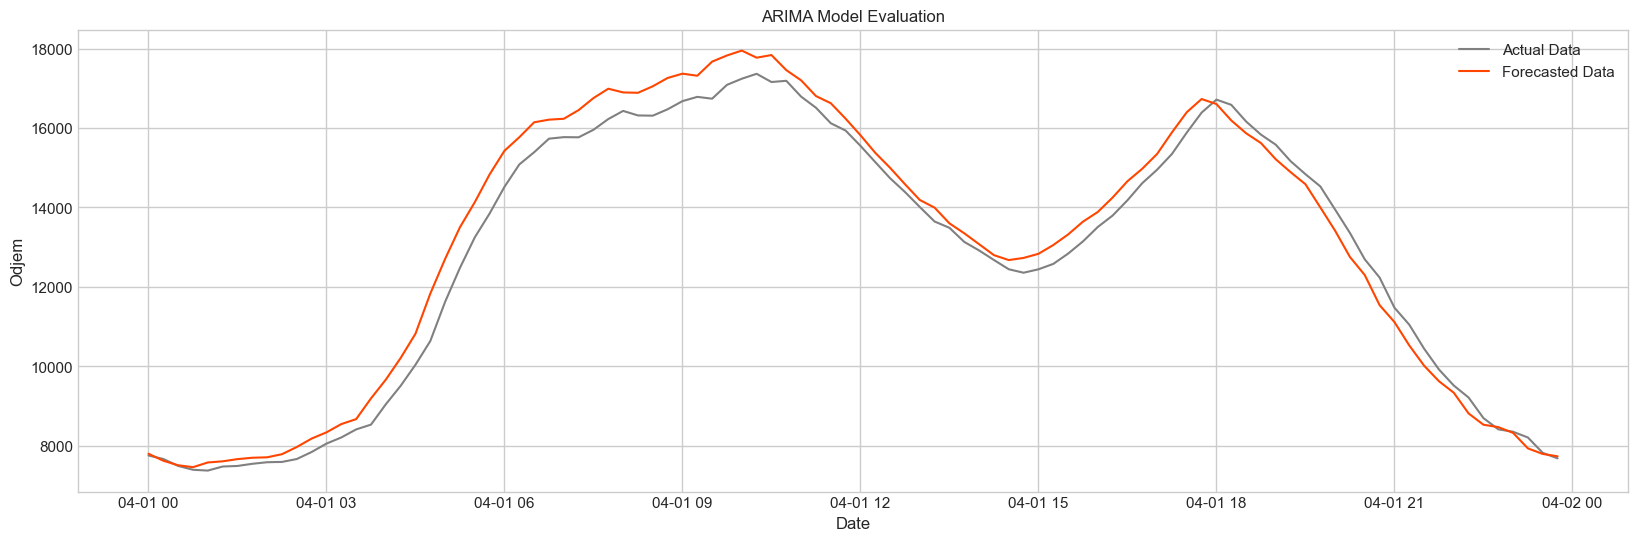

In [18]:
test_forecast_2 = results_2.forecast(steps=96, exog=test_exog)

# import math

napoved_2 = np.exp(test_forecast_2 + np.log(podatki.loc['2023-04-01 00:00:00':'2023-04-02 00:00:00', 'Odjem ACT'].shift(-1)['2023-04-01']))
napoved_2

plt.plot(podatki.loc['2023-04-01', 'Odjem ACT'], label='Actual Data', color='gray')
plt.plot(napoved_2, label='Forecasted Data', color='orangered')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Odjem')
plt.legend()
plt.show()


In [9]:
def ARIMA_no_exog(p, d, q, train):
    model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q))
    results = model.fit()
    return results

def ARIMA_exog(p, d, q, train, exog):
    model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), exog = exog)
    results = model.fit()
    return results

def GARCH (residuali, p, q):
    model = arch.arch_model(residuali, mean='Zero', vol='Garch', p=p, q=q)
    results = model.fit()
    return results

def forecast_no_exog (results, steps):
    return results.forecast(steps)

def forecast_exog (results, steps, exog):
    return results.forecast(steps, exog)

In [10]:
results_1 = ARIMA_exog(1, 1, 0, train_data_diff_96, train_exog)
# 13.2s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
results_2 = ARIMA_exog(0, 1, 1, train_data_diff_96, train_exog)
# 19.4s

In [12]:
results_3 = ARIMA_exog(1, 1, 1, train_data_diff_96, train_exog)
# 42.0s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
results_4 = ARIMA_exog(2, 1, 2, train_data_diff_96, train_exog)
# 25.6s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
results_5 = ARIMA_exog(3, 1, 2, train_data_diff_96, train_exog)
# 26.4s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
results_6 = ARIMA_exog(4, 1, 3, train_data_diff_96, train_exog)
# 1m 56.9s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
results_7 = ARIMA_exog(5, 1, 4, train_data_diff_96, train_exog)
# 1m 50.1s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [17]:
results_8 = ARIMA_exog(5, 1, 5, train_data_diff_96, train_exog)
# 1m 54.2s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [18]:
results_9 = ARIMA_exog(4, 1, 5, train_data_diff_96, train_exog)
# 59.9s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
results_10 = ARIMA_exog(6, 1, 5, train_data_diff_96, train_exog)
# 2m 56.1s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
results_11 = ARIMA_exog(6, 1, 6, train_data_diff_96, train_exog) 
# 3m 12.1s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [22]:
results_12 = ARIMA_exog(5, 1, 6, train_data_diff_96, train_exog) 
# 2m 8.5s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [27]:
pd.DataFrame([
    ['SARIMA(1,1,0)(0,1,0)[96]', results_1.aic], 
    ['SARIMA(0,1,1)(0,1,0)[96]', results_2.aic], 
    ['SARIMA(1,1,1)(0,1,0)[96]', results_3.aic], 
    ['SARIMA(2,1,1)(0,1,0)[96]', results_4.aic], 
    ['SARIMA(3,1,2)(0,1,0)[96]', results_5.aic],
    ['SARIMA(4,1,3)(0,1,0)[96]', results_6.aic], 
    ['SARIMA(5,1,4)(0,1,0)[96]', results_7.aic], 
    ['SARIMA(5,1,5)(0,1,0)[96]', results_8.aic], 
    ['SARIMA(4,1,5)(0,1,0)[96]', results_9.aic], 
    ['SARIMA(6,1,5)(0,1,0)[96]', results_10.aic], 
    ['SARIMA(6,1,6)(0,1,0)[96]', results_11.aic], 
    ['SARIMA(5,1,6)(0,1,0)[96]', results_12.aic]
],
columns=('Model', 'AIC'))

# najboljši je SARIMA(4,1,5) --> results_9

,Model,AIC
0,"SARIMA(1,1,0)(0,1,0)[96]",-338588.046330
1,"SARIMA(0,1,1)(0,1,0)[96]",-346718.519174
2,"SARIMA(1,1,1)(0,1,0)[96]",-346768.583304
3,"SARIMA(2,1,1)(0,1,0)[96]",-347555.506685
4,"SARIMA(3,1,2)(0,1,0)[96]",-347573.393767
5,"SARIMA(4,1,3)(0,1,0)[96]",-278981.697958
6,"SARIMA(5,1,4)(0,1,0)[96]",-345287.412681
7,"SARIMA(5,1,5)(0,1,0)[96]",-345310.104621
8,"SARIMA(4,1,5)(0,1,0)[96]",-347619.304177
9,"SARIMA(6,1,5)(0,1,0)[96]",-345325.841533


In [120]:
model_3 = sm.tsa.statespace.SARIMAX(train_data_diff_96, order=(5,1,4), exog = train_exog)
results_3 = model_3.fit()
sarima_residuals_3 = results_3.resid
# results_3.aic

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [125]:
results_3.aic

-345287.4126805413

In [131]:
modelcek = ARIMA_exog(5,1,4,train_data_diff_96,train_exog)

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [121]:
modelGARCH_3 = arch.arch_model(sarima_residuals_3, mean='Zero', vol='Garch', p=1, q=1)
resultGarch_3 = modelGARCH_3.fit()

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: -181846.61026933504
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -181846.6108027955
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [50]:
print(results_3.aic)
print(resultGarch_3.aic)

-50569.64580077558
-52091.57847699028


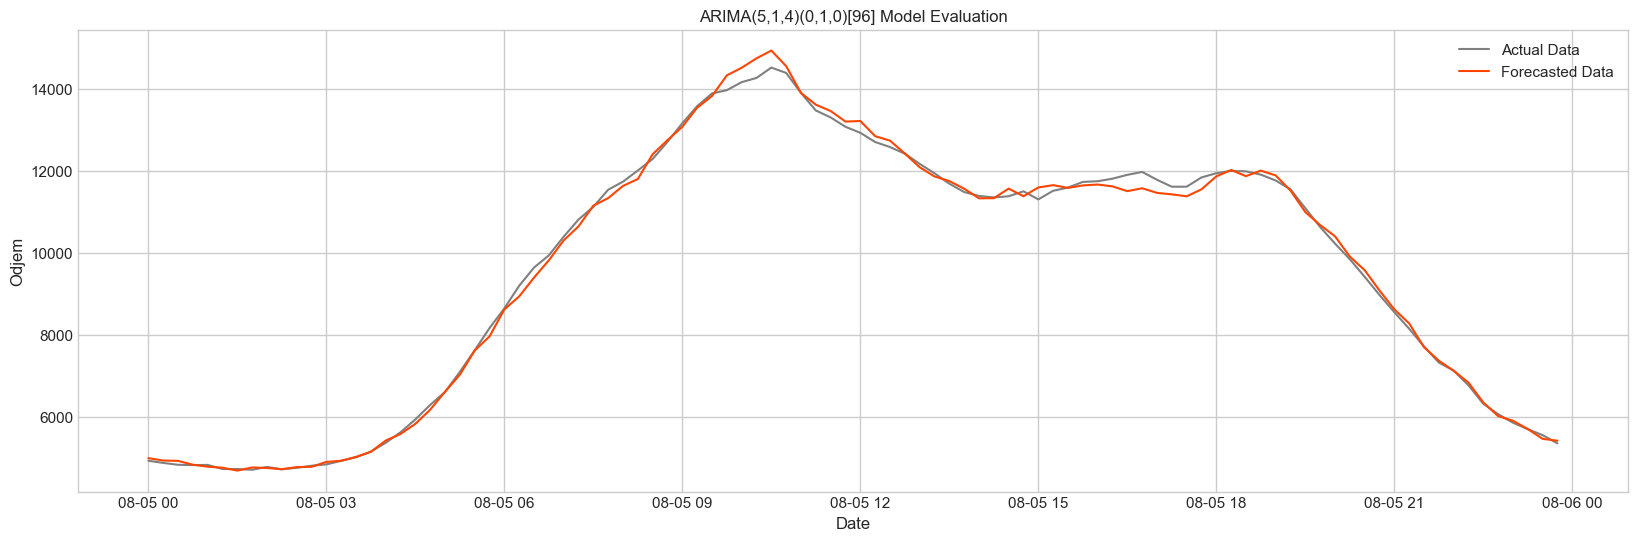

In [123]:
test_forecast_3 = results_3.forecast(steps=96, exog=test_exog)

napoved_3_ = test_forecast_3 + podatki['log return'].shift(-96)['2023-08-05']

napoved_3 = np.exp(napoved_3_ + np.log(podatki.loc['2023-08-05 00:00:00':'2023-08-06 00:00:00', 'Odjem ACT'].shift(-1)['2023-08-05']))

plt.plot(podatki.loc['2023-08-05', 'Odjem ACT'], label='Actual Data', color='gray')
plt.plot(napoved_3, label='Forecasted Data', color='orangered')
plt.title('ARIMA(5,1,4)(0,1,0)[96] Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Odjem')
plt.legend()
plt.show()